# Неделя 10. Работа с несбалансированными данными

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### <font color='scarlett'> Для получения верных отвтеов необходимы следующие версии бибилотек:

In [2]:
#!pip install -U scikit-learn==0.21.3

In [3]:
import sklearn
import imblearn

print(sklearn.__version__)
print(imblearn.__version__)

C:\Users\Dmitry\Anaconda\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


0.21.3
0.4.3


## <font color="purple"> Загрузка данных

В используемом наборе данных собрана информация об оттоке клиентов телекоммуникационной компании.

__Задача__: определить лояльность клиента

    Признак "churn": 1 - перестал быть клиентом, 0 - продолжил пользоваться услугами компании
    
    Верно определяя абонентов, которые могут отказаться от услуг компании, бизнес может предпринять меры и минимизировать отток клиентов. Например, предлагать персональные скидки, предоставлять пакеты минут и т.п.

In [4]:
data = pd.read_csv("churn.csv")
data.shape

(3333, 21)

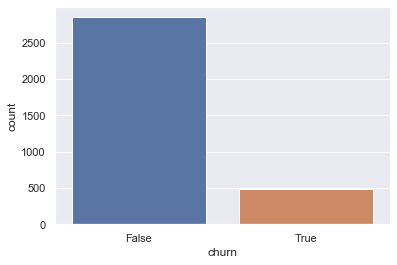

In [5]:
# посмотрим на распределение
sns.set(style="darkgrid")
sns.countplot(x="churn", data=data)

In [6]:
data['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

Очевидно, что большинство абонентов не отказываются от услуг. Компании необходимо разработать классификатор, находящий как можно больше редких недовольных клиентов. 

In [7]:
# уберем колонки Штат абонента, Тел.номер абонента
data.drop(['state','phone number'],axis=1,inplace=True)

In [8]:
# закодируем категориальные переменные
data["international plan"] = data["international plan"].map({"no":0,"yes":1})
data["voice mail plan"] = data["voice mail plan"].map({"no":0,"yes":1})

## <font color="purple"> Разделение выборки на обучение и контроль

Не забудем указать стратификацию по целевой переменной, чтобы сохранить исходное распределение классов.

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, stratify=data['churn'], random_state=1)
train.shape, test.shape

((2666, 19), (667, 19))

In [10]:
X_train = train.drop('churn', axis=1)
y_train = train['churn'].astype(int)

X_test = test.drop('churn', axis=1)
y_test = test['churn'].astype(int)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2666, 18), (2666,), (667, 18), (667,))

## <font color="purple"> Кросс-валидация

### <font color='orange'> __Важно!__

Подбор оптимальной стратегии ресемплинга необходимо производить на кросс-валидации. Таким образом мы избежим подстраивания под данные тестовой выборки. Это позволит получить реалистичную оценку качества построенной модели.

### Задание 1. 

В качестве бейзлайна построим логистическую регрессию. 
1. Для оценки качества воспользуйтесь функцией cross_val_score из библиотеки sklearn.
    - Подумайте, какую стратегию кросс-валидации применить. Выберите нужную, укажите разбиение на 5 фолдов.
    - В качестве оцениваемой метрики выберите полноту.
    - Определите среднее значение, вовзращаемое функцией (используйте метод .mean()).
3. Ответ округлите до трех знаков после запятой. Внесите в гугл-форму __"Вопрос 1"__.

__NB__: Для воспроизводимости результатов и получения правильного ответа __во всех алгоритмах и методах__ нужно установить параметр random_seed=1!

In [11]:
#### ваш код ####
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

log_r = LogisticRegression(random_state=1)
cv_scores = cross_val_score(estimator=log_r, X=X_train, y=y_train, scoring='recall', cv=skf)

print(round(cv_scores.mean(),3))


0.189


### Задание 2.

1. Допишите функцию K-fold валидации (resamped_cv_scores), позволяющую произвести ресемплинг на K-1 фолдах, не затронув тестовый фолд. Функция принимает на вход объект алгоритма классификации, датафрейм признаков (независимых переменных), целевую переменную. Функция должна возвращать среднюю (используйте метод .mean()) оценку качества модели по всем K-фолдам.

2. В качестве алгоритма классификации используйте логистическую регрессию.

3. Ответ округлите до трех знаков после запятой. Внесите в гугл-форму __"Вопрос 2"__.

__NB__: Для воспроизводимости результатов и получения правильного ответа __во всех алгоритмах и методах__ нужно установить параметр random_seed=1!

In [12]:
from imblearn.combine import SMOTEENN #RandomOverSampler
from sklearn.metrics import recall_score

def resamped_cv_scores(model, X, y):
    # Выбрать подходящий объект для кросс-валидации из классов sklearn.model_selection,
    # разбить выборку на 5 фолдов
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    #### ваш код ####
    
    # Выбрать алгоритм из библиотеки imblearn, производящий oversampling с 
    # последующим очищением с помощью алгоритма k-ближайших соседей.
    # Все параметры оставьте по умолчанию, кроме random_state.
    #ros = RandomOverSampler(random_state=1)
    sm = SMOTEENN(random_state=1)
    #### ваш код #### 
    
    cv_scores = []
    for train_index, test_index in skf.split(X, y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Делаем ресемплинг на трейне
        #X_resampled, y_resampled = ros.fit_sample(X_train, y_train) #### ваш код ####
        X_resampled, y_resampled = sm.fit_sample(X_train, y_train)

        # Обучаем модель на данных трейна после ресемплинга
        model_obj = model.fit(X_resampled, y_resampled)
        
        # Оцениваем качество модели на тестовой выборке, неподвергавшейся ресемплингу
        # Необходимая нам метрика - полнота модели
        cv_scores.append(recall_score(y_test, model.predict(X_test)))
        #### ваш код ####
        
    return np.array(cv_scores).mean() #### ваш код ####

In [13]:
#### ваш код ####
mean = resamped_cv_scores(LogisticRegression(random_state=1), X_train, y_train)

In [14]:
round(mean, 3)

0.826

## <font color="purple"> Немного теории

### Задание 3

В предыдущем задании вами была использована одна из модификаций метода oversampling с последующим удалением объектов, определяемых с помощью k-ближайших соседей. Кратко и точно объясните правило, по которому выбирались объекты для удаления __конкретно__ в нашем примере.


- Ответ внесите в гугл-форму __"Вопрос 3"__.

**<font color='red'>Answer:** выбирались объекты c меткой 0 (мажоритарный класс), для каждого из находились k ближайших соседей, если оказывалось, что ближайшим соседом является объект с меткой 1 (минорный класс), то объект мажориторного класса удалялся

### Задание 4

На лекции мы познакомились с контролируемым методом undersampling'а - NearMiss. Мы разобрали работу одной из трех вариаций алгоритма. Кстати, именно ту, что заложена по умолчанию в библиотеки imblearn.

1. Кратко объясните, как работает NearMiss-2.
    - Ответ внесите в гугл-форму __"Вопрос 4.1"__.


2. Кратко объясните, как работает NearMiss-3.
    - Ответ внесите в гугл-форму __"Вопрос 4.2"__.

**Answer:** 
    1. отбираются те объекты мажоритарного класса, чье среднее расстояние до k наиболее удаленных объектов минорного класса наименьшее
    2. отбираются те объекты мажоритарного класса, чье расстояние до каждого из k объектов минорного класса наименьшее 

## <font color="purple"> Моделирование и тестирование

### Задание 5

На кросс-валидации мы убедились, что качество модели улучшается при использовании методов ресемплинга. Теперь мы построим модель и оценим качество классификации.

- Произведите ресемплинг обучающей выборки с помощью метода, использованного вами в __Задание 2__. На полученных данных обучите алгоритм логистической регрессии. Сделайте прогнозы на тестовой выборке.
- Отрисуйте матрицу ошибок с помощью функции draw_cm.
- Выведите classification_report для быстрой оценки метрик по обоим классам.

Вопросы:

1. Сколько __новых__ синтетических примеров было сгенерировано классом, который вы использовали для ресемплинга. 
    - Ответ запишите в гугл-форму __"Вопрос 5.1"__.
    
    
2. Как называются объекты указаные в левом нижнем углу и в правом верхнем углу матрицы ошибок? Попробуйте поиграть с параметром normalize. Обратите внимание на подписи к осям.
    - Ответ запишите в гугл-форму __"Вопрос 5.2"__.
    
    
3. Какую из четырех категорий хочет минимизировать телекоммуникационная компания, если хочет сохранить как можно больше клиентов? Какую максимизировать?
    - Ответ запишите в гугл-форму __"Вопрос 5.3"__.
    
    
__NB__: Для воспроизводимости результатов и получения правильного ответа __во всех алгоритмах и методах__ нужно установить параметр random_seed=1!

In [15]:
sm = SMOTEENN(random_state=1)
X_resampled, y_resampled = sm.fit_sample(X_train, y_train)

new_logreg = LogisticRegression(random_state=1)
new_logreg.fit(X_resampled, y_resampled)
y_pred = new_logreg.predict(X_test)

In [16]:
def draw_cm(cm, classes, normalize=True):
    """
    Функция для отрисовки матрицы ошибок
        cm: Матрица ошибок
        classes: список классов
    """
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize = (6,5))
    
    if normalize:
        df_cm = pd.DataFrame(cm_norm, index = [i for i in classes],
                             columns = [i for i in classes])
        sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.2g')
    else:
        df_cm = pd.DataFrame(cm, index = [i for i in classes],
                         columns = [i for i in classes])
        sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')
        
    plt.title('Матрица ошибок', fontsize=15)
    plt.xlabel('Истинный класс', fontsize=12)
    plt.ylabel('Предсказанный класс', fontsize=12)

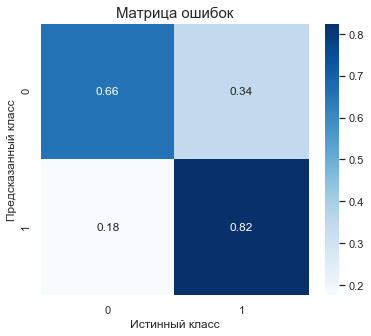

In [17]:
#### ваш код ####
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
classes = [0, 1]
draw_cm(cm, classes)

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,[0,1]))

              precision    recall  f1-score   support

           0       0.96      0.66      0.78       570
           1       0.29      0.82      0.43        97

    accuracy                           0.68       667
   macro avg       0.62      0.74      0.60       667
weighted avg       0.86      0.68      0.73       667



**Answer 1:**

In [21]:
y_resampled.shape[0]-y_train.shape[0]

784

**Answer 2:**

Левый нижний угол- FalseNegative
Верхний правый угол - FalsePositive

**Answer 3:**

Максимизировать - precision\ \\\
Минимизировать - 

## <font color="purple"> Обучение ансамблей на сбалансированных подвыборках

### Задание 6

Библиотека imblearn также предоставляет возможность обучения ансамблей на сбалансированных подвыборках. Примером может служить класс BalancedRandomForestClassifier.

1. Кратко опишите, как работает реализация данного класса.
    - Ответ запишите в гугл-форму __"Вопрос 6.1"__


2. Импортируйте класс в ноутбук и постройте с его помощью классификатор. 
        - Все параметры оставьте по умолчанию, кроме двух: глубину дерева установите равной 3, random_state=1.
        - Создайте прогнозы на тестовой выборке.
        - Отрисуйте матрицу ошибок с помощью функции draw_cm.
        - Выведите classification_report для быстрой оценки метрик по обоим классам.

3. Оцените полноту модели. Ответ округлите до трех знаков после запятой.
    - Ответ запишите в гугл-форму __"Вопрос 6.2"__
    
    
4. Исследуйте созданный вами classification_report. По сравнению с моделью в __Задании 5__ увеличилась ли полнота мажорного класа, минорного класса или обоих классов??
    - Ответ запишите в гугл-форму __"Вопрос 6.3"__
    
__NB__: Для воспроизводимости результатов и получения правильного ответа __во всех алгоритмах и методах__ нужно установить параметр random_seed=1!

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       570
           1       0.55      0.85      0.66        97

    accuracy                           0.88       667
   macro avg       0.76      0.86      0.79       667
weighted avg       0.91      0.88      0.89       667



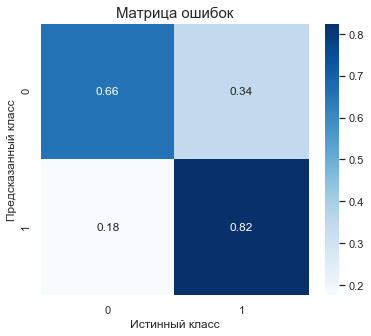

In [25]:
#### ваш код ####
from imblearn.ensemble import BalancedRandomForestClassifier

cls = BalancedRandomForestClassifier(max_depth=3, random_state=1)
cls.fit(X_train, y_train)
y_preds = cls.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
classes = [0, 1]
draw_cm(cm, classes)

print(classification_report(y_test, y_preds, [0, 1]))

In [27]:
round(0.66/(0.66+0.18),3)

0.786